[![Open in Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/fat-forensics/resources/master?filepath=fat_forensics_overview%2FFAT_Forensics.ipynb)
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/fat-forensics/resources/blob/master/fat_forensics_overview/FAT_Forensics.ipynb)
[![new BSD](https://img.shields.io/github/license/fat-forensics/resources.svg)](https://github.com/fat-forensics/resources/blob/master/LICENCE)

# FAT Forensics: A Python Toolbox for Algorithmic Fairness, Accountability and Transparency #

This directory contains a Jupyter Notebook that can be used to reproduce the
results presented in the "*FAT Forensics: A Python Toolbox for Algorithmic
Fairness, Accountability and Transparency*" paper.

The manuscript is available on [arXiv][arXiv:1909.05167].

To run the notebook (`FAT_Forensics.ipynb`) you need to install a collection of
Python dependencies listed in the `requirements.txt` file (included in this
directory) by executing `pip install -r requirements.txt`.
Alternatively, you can run it via Binder or Colab by clicking the buttons
included above.

## Abstract ##

> Machine learning algorithms can take important, and sometimes legally binding,
> decisions about our everyday life.
> In many cases, however, these systems and their actions are neither regulated
> nor certified.
> Given the potential harm that such algorithms can cause, their fairness,
> accountability and transparency are of paramount importance.
> Recent literature suggested voluntary self-reporting on these aspects of
> predictive systems -- e.g., "datasheets for datasets" -- but their scope is
> often limited to a single component of a machine learning pipeline and their
> composition requires manual labour.
> To resolve this impasse and ensure high-quality, fair, transparent and
> reliable data-driven models, we developed an open source toolbox that can
> analyse selected fairness, accountability and transparency characteristics
> of these systems to automatically and objectively report them to relevant
> stakeholders.
> The software provides functionality for inspecting the aforementioned
> properties of all aspects of the machine learning process: data
> (and their features), models and predictions.
> In this paper we describe the design, scope and usage examples of this Python
> package, which is published under the BSD 3-Clause open source licence.

## BibTeX ##
```
@article{sokol2019fat,
  title={{FAT} {F}orensics: {A} {P}ython toolbox for algorithmic fairness,
         accountability and transparency},
  author={Sokol, Kacper and Santos-Rodriguez, Raul and Flach, Peter},
  journal={arXiv preprint arXiv:1909.05167},
  year={2019}
}
```

[arXiv:1909.05167]: https://arxiv.org/abs/1909.05167

## Set up the notebook ##

Import auxiliary modules and set up the environment (FAT Forensics random seed and matplotlib plotting colour-scheme).

In [1]:
# NBVAL_IGNORE_OUTPUT
import os
if 'google.colab' in str(get_ipython()):
    LIBRARY_URL = ('https://raw.githubusercontent.com/fat-forensics/resources/'
                   'master/fat_forensics_overview/{}')
    require = 'requirements.txt'
    require_url = LIBRARY_URL.format(require)
    if not os.path.exists(require):
        ! wget $require_url -O $require
        ! pip install -r $require

In [2]:
import scipy
import scipy.stats

import sklearn.datasets
import sklearn.metrics
import sklearn.model_selection

import matplotlib.pyplot as plt
import matplotlib.colors as plt_colors
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, Ridge
# from sklearn.svm import SVC
from sklearn.tree import DecisionTreeRegressor

from sklearn.preprocessing import MinMaxScaler  # , StandardScaler

%matplotlib inline

In [3]:
import fatf

In [4]:
random_seed = 42
fatf.setup_random_seed(random_seed)

plt.style.use('seaborn')

22-Mar-22 00:23:30 fatf         INFO     Seeding RNGs using the input parameter.
22-Mar-22 00:23:30 fatf         INFO     Seeding RNGs with 42.


In [5]:
cc = plt.get_cmap('Pastel1')
colours = [plt_colors.rgb2hex(cc(i)) for i in range(cc.N)]
cmap_green_red = plt_colors.ListedColormap([colours[2], colours[0]])  # 'green', 'red'
cc_ = plt.get_cmap('Set1')
colours_ = [plt_colors.rgb2hex(cc_(i)) for i in range(cc_.N)]
cmap_red_blue = plt_colors.ListedColormap([colours_[0], colours_[1]])

## Watermark the notebook ##

In [6]:
# NBVAL_IGNORE_OUTPUT
%load_ext watermark
%watermark -v -m -p fatf,matplotlib,numpy,pandas,scipy,seaborn,sklearn

CPython 3.7.9
IPython 7.23.1

fatf 0.1.0
matplotlib 3.1.0
numpy 1.16.4
pandas 0.25.0
scipy 1.3.0
seaborn 0.9.0
sklearn 0.21.1

compiler   : Clang 12.0.0 (clang-1200.0.32.29)
system     : Darwin
release    : 19.6.0
machine    : x86_64
processor  : i386
CPU cores  : 4
interpreter: 64bit


## FAT Forensics Use Cases ##

### Prepare the Adult data set ###
Download and pre-process the [Adult data set][adult] (UCI Census Income) to use with our experiments.
(This data set is popular in algorithmic fairness research.)

[adult]: http://archive.ics.uci.edu/ml/datasets/Census+Income

In [7]:
# NBVAL_IGNORE_OUTPUT
# Download census
if not os.path.exists('adult.data'):
    ! wget http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data

--2022-03-22 00:23:32--  http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3974305 (3.8M) [application/x-httpd-php]
Saving to: ‘adult.data’

adult.data          100%[===================>]   3.79M  1.45MB/s    in 2.6s    

2022-03-26 11:58:45 (1.45 MB/s) - ‘adult.data’ saved [3974305/3974305]



In [8]:
# Specify census feature names
census_names = [
    'age',
    'workclass',
    'fnlwgt',
    'education',
    'education-num',
    'marital-status',
    'occupation',
    'relationship',
    'race',
    'sex',
    'capital-gain',
    'capital-loss',
    'hours-per-week',
    'native-country',
    'income'
]

# Load census into a dataframe
df = pd.read_csv('adult.data', names=census_names, skipinitialspace=True)

# Remove missing values
df = df[df != '?']

# Get feature mapping to create a purely numerical data array
features_unique = {
    'workclass': df['workclass'].unique(),
    'education': np.sort(df['education'].unique()),
    'marital-status': np.sort(df['marital-status'].unique()),
    'occupation': df['occupation'].unique(),
    'relationship': np.sort(df['relationship'].unique()),
    'race': np.sort(df['race'].unique()),
    'sex': np.sort(df['sex'].unique()),
    'native-country': df['native-country'].unique(),
    'income': np.sort(df['income'].unique())
}

df_unmapped = df.copy()

map_i_s = {}
map_s_i = {}
for feature_name in features_unique:
    map_i_s[feature_name] = dict()
    map_s_i[feature_name] = dict()
    for i, value in enumerate(features_unique[feature_name]):
        map_i_s[feature_name][i] = value
        map_s_i[feature_name][value] = i
        
# Map the categorical features to numbers
for feature_name in map_s_i:
    df[feature_name] = df[feature_name].map(map_s_i[feature_name])

# Split the array into X and y
data_array = df.drop('income', axis=1).values
ground_truth = df['income'].values

/Python/3.7.9/lib/python3.7/site-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


In [9]:
# Train a classifier
clf = LogisticRegression(solver='lbfgs')  # SVC()
clf.fit(data_array, ground_truth)

LogisticRegression()

### Grouping for fairness, accountability and transparency ###
Let's group the data set based on the `race` feature.

In [10]:
import fatf.utils.data.tools as fatf_data_tools
import fatf.transparency.data.describe_functions as fatf_describe_data

22-Mar-22 00:23:41 fatf.utils.array.tools INFO     Using numpy's numpy.lib.recfunctions.structured_to_unstructured as fatf.utils.array.tools.structured_to_unstructured and fatf.utils.array.tools.structured_to_unstructured_row.


In [11]:
race_index = census_names.index('race')

#### Grouping for group-based data transparency ####

In [12]:
race_grouping = fatf_data_tools.group_by_column(
    data_array, race_index, treat_as_categorical=True)

In [13]:
# race_grouping
race_grouping[1]

['(0,)', '(1,)', '(2,)', '(3,)', '(4,)']

In [14]:
features_unique['race']

array(['Amer-Indian-Eskimo', 'Asian-Pac-Islander', 'Black', 'Other',
       'White'], dtype=object)

Amer-Indian-Eskimo


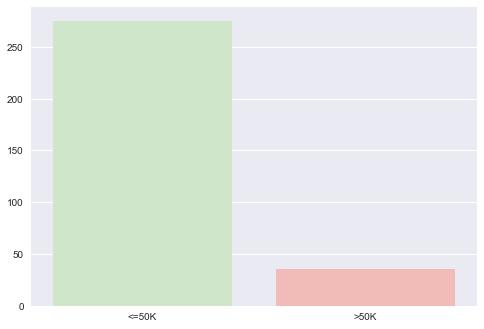

Asian-Pac-Islander


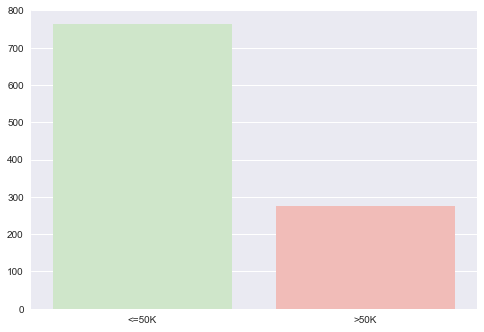

Black


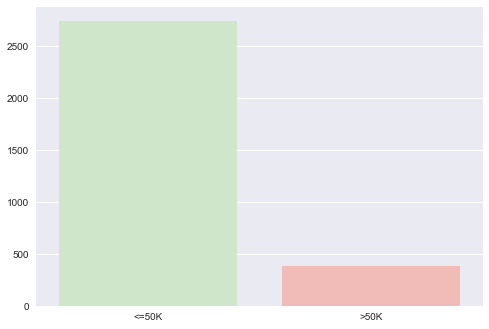

Other


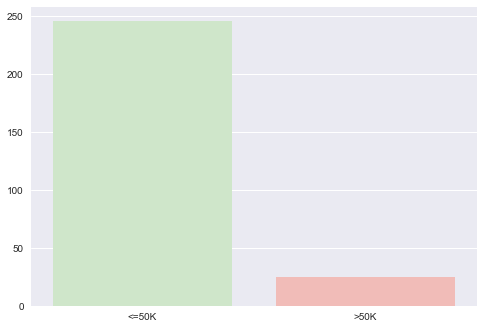

White


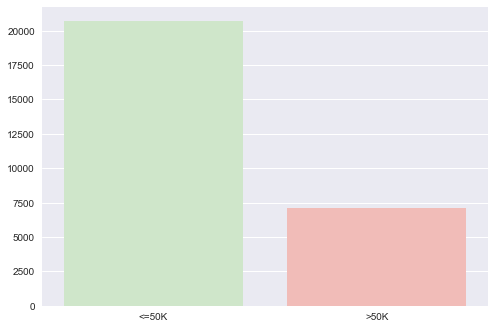

In [15]:
for i, race in enumerate(features_unique['race']):
    desc = fatf_describe_data.describe_categorical_array(
        ground_truth[race_grouping[0][i]].astype('str'))
    
    print(race)
    sns.barplot(
        x=features_unique['income'],
        y=desc['unique_counts'],
        palette=[colours[2], colours[0]])
    # plt.title(race)
    plt.savefig(
        f'group_transparency_{race}.pdf', dpi=300, bbox_inches='tight', pad_inches=0)
    plt.show()

#### Grouping for group-based fairness ####

In [16]:
import fatf.fairness.models.measures as fatf_fairness_models

import fatf.utils.metrics.tools as fatf_metric_tools
import fatf.utils.metrics.metrics as fatf_performance_metrics

In [17]:
adult_predictions = clf.predict(data_array)

In [18]:
confusion_matrix = fatf_metric_tools.get_confusion_matrix(
    ground_truth, adult_predictions)

In [19]:
fatf_performance_metrics.accuracy(confusion_matrix)

0.7957372316575044

In [20]:
race_cm = fatf_metric_tools.confusion_matrix_per_subgroup_indexed(
    race_grouping[0],
    ground_truth,
    adult_predictions,
    labels=np.unique(ground_truth).tolist())

In [21]:
race_equal_accuracy = fatf_fairness_models.equal_accuracy(race_cm, tolerance=0.14)

In [22]:
race_equal_accuracy

array([[False, False, False, False, False],
       [False, False, False,  True, False],
       [False, False, False, False, False],
       [False,  True, False, False, False],
       [False, False, False, False, False]])

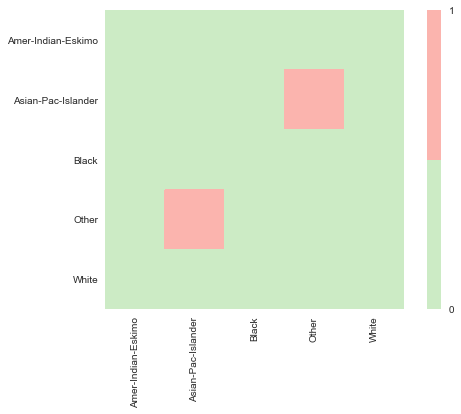

In [23]:
sns.heatmap(
    race_equal_accuracy,
    square=True,
    xticklabels=features_unique['race'],
    yticklabels=features_unique['race'],
    cmap=cmap_green_red,
    cbar_kws=dict(ticks=[0, 1]),
    vmin=0, vmax=1, center=.5)
plt.savefig(
    f'fairness_race_equal_accuracy.pdf',
    dpi=300,
    bbox_inches='tight',
    pad_inches=0)

In [24]:
race_equal_opportunity = fatf_fairness_models.equal_opportunity(
    race_cm, tolerance=0.14)

In [25]:
race_equal_opportunity

array([[False, False, False, False, False],
       [False, False, False, False, False],
       [False, False, False, False, False],
       [False, False, False, False, False],
       [False, False, False, False, False]])

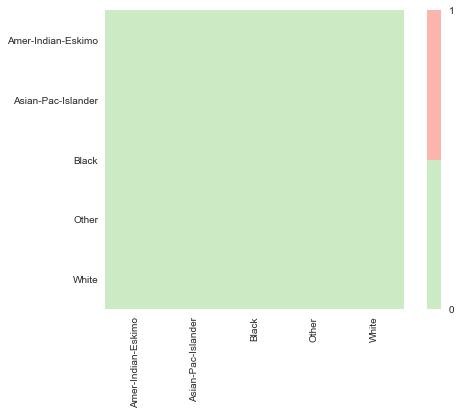

In [26]:
sns.heatmap(
    race_equal_opportunity,
    square=True,
    xticklabels=features_unique['race'],
    yticklabels=features_unique['race'],
    cmap=cmap_green_red,
    cbar_kws=dict(ticks=[0, 1]),
    vmin=0, vmax=1, center=.5)
plt.savefig(
    f'fairness_race_equal_opportunity.pdf',
    dpi=300,
    bbox_inches='tight',
    pad_inches=0)

In [27]:
race_demographic_parity = fatf_fairness_models.demographic_parity(
    race_cm, tolerance=0.14)

In [28]:
race_demographic_parity

array([[False, False, False, False, False],
       [False, False, False,  True, False],
       [False, False, False, False, False],
       [False,  True, False, False,  True],
       [False, False, False,  True, False]])

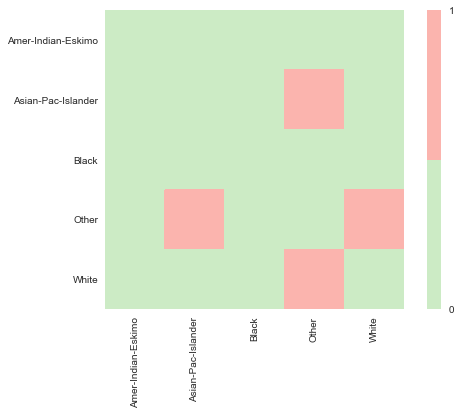

In [29]:
sns.heatmap(
    race_demographic_parity,
    square=True,
    xticklabels=features_unique['race'],
    yticklabels=features_unique['race'],
    cmap=cmap_green_red,
    cbar_kws=dict(ticks=[0, 1]),
    vmin=0, vmax=1, center=.5)
plt.savefig(
    f'fairness_race_demographic_parity.pdf',
    dpi=300,
    bbox_inches='tight',
    pad_inches=0)

#### Grouping for group-based performance disparity ####

In [30]:
import fatf.utils.metrics.subgroup_metrics as subgroup_metrics
import fatf.accountability.models.measures as fatf_accountability_models_measures

In [31]:
race_accuracy = subgroup_metrics.apply_metric(
    race_cm, metric='accuracy')

In [32]:
race_accuracy_bias = fatf_accountability_models_measures.systematic_performance_bias_grid(
    race_accuracy, threshold=0.83)

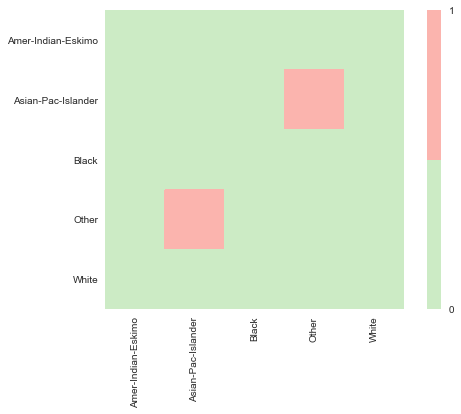

In [33]:
sns.heatmap(
    race_accuracy_bias,
    square=True,
    xticklabels=features_unique['race'],
    yticklabels=features_unique['race'],
    cmap=cmap_green_red,
    cbar_kws=dict(ticks=[0, 1]),
    vmin=0, vmax=1, center=.5)
plt.savefig(
    f'performance_accuracy_bias.pdf',
    dpi=300,
    bbox_inches='tight',
    pad_inches=0)

In [34]:
race_tnr = subgroup_metrics.apply_metric(
    race_cm, metric='true negative rate')

In [35]:
race_tnr_bias = fatf_accountability_models_measures.systematic_performance_bias_grid(
    race_tnr, threshold=0.83)

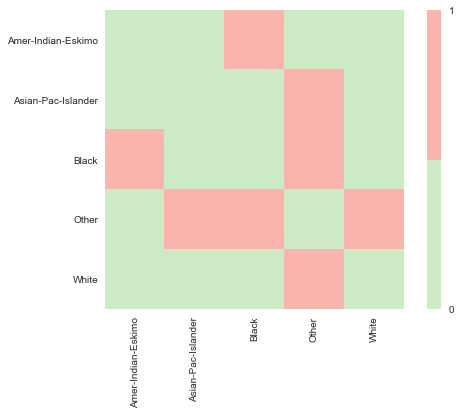

In [36]:
sns.heatmap(
    race_tnr_bias,
    square=True,
    xticklabels=features_unique['race'],
    yticklabels=features_unique['race'],
    cmap=cmap_green_red,
    cbar_kws=dict(ticks=[0, 1]),
    vmin=0, vmax=1, center=.5)
plt.savefig(
    f'performance_tnr_bias.pdf',
    dpi=300,
    bbox_inches='tight',
    pad_inches=0)

### Data density for robust and feasible counterfactuals ###

#### Assess robustness of a prediction with data density ####

In [37]:
import fatf.utils.data.density as fatf_density

In [38]:
adult_density = fatf_density.DensityCheck(
    data_array[:1000, :],  # 10000
    distance_function=scipy.spatial.distance.euclidean)

In [39]:
data_point_index_dense_1 = 42
data_point_index_dense_2 = 142
data_point_index_sparse_1 = 5369  # 414
data_point_index_sparse_2 = 8258  # 1597

In [40]:
for i in [data_point_index_dense_1,
          data_point_index_dense_2,
          data_point_index_sparse_1,
          data_point_index_sparse_2]:
    x = data_array[i, :]
    print('Data point index: {}'.format(i))
    print('Density score: {}'.format(adult_density.score_data_point(x)))
    print('Ground truth: {}'.format(ground_truth[i]))
    print('Prediction: {}'.format(clf.predict([x])[0]))
    print('\n-----------------------\n')

Data point index: 42
Density score: 0.0017474497191807704
Ground truth: 0
Prediction: 0

-----------------------

Data point index: 142
Density score: 0.002352305557595431
Ground truth: 0
Prediction: 0

-----------------------

Data point index: 5369
Density score: 1
Ground truth: 0
Prediction: 0

-----------------------

Data point index: 8258
Density score: 1
Ground truth: 1
Prediction: 0

-----------------------



In [41]:
df_unmapped.iloc[data_point_index_sparse_2]

age                               35
workclass                    Private
fnlwgt                       1226583
education                  Bachelors
education-num                     13
marital-status    Married-civ-spouse
occupation                     Sales
relationship                 Husband
race                           White
sex                             Male
capital-gain                       0
capital-loss                       0
hours-per-week                    52
native-country         United-States
income                          >50K
Name: 8258, dtype: object

In [42]:
df_unmapped.fnlwgt.describe()

count    3.256100e+04
mean     1.897784e+05
std      1.055500e+05
min      1.228500e+04
25%      1.178270e+05
50%      1.783560e+05
75%      2.370510e+05
max      1.484705e+06
Name: fnlwgt, dtype: float64

In [43]:
scipy.stats.percentileofscore(
    df_unmapped.fnlwgt.values,
    1226583)

99.98771536500722

#### Assess feasibility of a counterfactual with data density ####

In [44]:
import fatf.transparency.predictions.counterfactuals as fatf_cf

In [45]:
categorical_features = [
    i for i, f_name in
    enumerate(census_names)
    if f_name in features_unique and f_name != 'income']

In [46]:
cf_explainer = fatf_cf.CounterfactualExplainer(
    model=clf,
    dataset=data_array,
    categorical_indices=categorical_features,
    default_numerical_step_size=100,
    step_sizes={census_names.index('age'): 5,
                census_names.index('fnlwgt'): 100,
                census_names.index('education-num'): 5,
                census_names.index('capital-gain'): 1000,
                census_names.index('capital-loss'): 1000,
                census_names.index('hours-per-week'): 2})

In [47]:
cf_explanations = cf_explainer.explain_instance(
    data_array[data_point_index_sparse_2, :])

In [48]:
cf_explanations

(array([[     35,       2, 1226583, ...,    4000,      52,       0],
        [     35,       2, 1226583, ...,       0,      52,       0],
        [     35,       2, 1226583, ...,       0,      52,       0],
        ...,
        [     35,       2, 1226583, ...,       0,      52,       0],
        [     37,       2, 1226583, ...,       0,      52,       0],
        [     35,       2,  430985, ...,    4000,      52,       0]]),
 array([ 21000,  25000,  25001,  25001,  25001,  25001,  25001,  25001,
         25001,  25001,  25001,  25001,  25001,  25001,  25001,  25001,
         25001,  25001,  25001,  25001,  25001,  25001,  25001,  25001,
         25001,  25001,  25001,  25001,  25001,  25001,  25001,  25001,
         25001,  25001,  25001,  25001,  25001,  25001,  25001,  25001,
         25001,  25001,  25001,  25001,  25001,  25001,  25001,  25001,
         25001,  25001,  25001,  25001,  25001,  25001,  25001,  25001,
         25001,  25001,  25001,  25001,  25001,  25001,  25001,  25

In [49]:
print(fatf_cf.textualise_counterfactuals(
    data_array[data_point_index_sparse_2, :],
    cf_explanations[0],
    0,
    cf_explanations[1],
    cf_explanations[2]))

Instance (of class *0*):
[     35       2 1226583       9      13       2       5       0       4
       1       0       0      52       0]

Feature names: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]

Counterfactual instance (of class *1*):
Distance: 21000
    feature *10*: *0* -> *17000*
    feature *11*: *0* -> *4000*

Counterfactual instance (of class *1*):
Distance: 25000
    feature *10*: *0* -> *25000*

Counterfactual instance (of class *1*):
Distance: 25001
    feature *1*: *2* -> *1*
    feature *10*: *0* -> *25000*

Counterfactual instance (of class *1*):
Distance: 25001
    feature *3*: *9* -> *0*
    feature *10*: *0* -> *25000*

Counterfactual instance (of class *1*):
Distance: 25001
    feature *3*: *9* -> *1*
    feature *10*: *0* -> *25000*

Counterfactual instance (of class *1*):
Distance: 25001
    feature *3*: *9* -> *2*
    feature *10*: *0* -> *25000*

Counterfactual instance (of class *1*):
Distance: 25001
    feature *3*: *9* -> *3*
    feature *10*: *0* -> *25

In [50]:
adult_density.score_data_point(cf_explanations[0][1])

1

In [51]:
adult_density.score_data_point(cf_explanations[0][-1])

0.022309939155656718

#### Counterfactual fairness -- uncover bias through explainability ####

In [52]:
cf_fairness = fatf_cf.CounterfactualExplainer(
    model=clf,
    dataset=data_array,
    categorical_indices=categorical_features,
    default_numerical_step_size=100,
    step_sizes={census_names.index('age'): 5,
                census_names.index('fnlwgt'): 100,
                census_names.index('education-num'): 5,
                census_names.index('capital-gain'): 1000,
                census_names.index('capital-loss'): 1000,
                census_names.index('hours-per-week'): 2},
    counterfactual_feature_indices=[0, 5, 7, 8, 9, 13])

In [53]:
cf_fair = cf_fairness.explain_instance(
    data_array[data_point_index_sparse_2, :])

In [54]:
cf_fair

(array([], shape=(0, 0), dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64))

### Local surrogates based on linear and logical models ###

In [55]:
import fatf.utils.kernels as fatf_kernels
import fatf.utils.distances as fatf_distances

from fatf.utils.data.augmentation import NormalSampling

In [56]:
def normalise_datasets(dataset):
    scaler = MinMaxScaler(feature_range=(0, 1)).fit(dataset)
    # scaler = StandardScaler(with_mean=True).fit(dataset)
    return scaler.transform(dataset)

# Load datasets
# 1/2 Moons
moons, moons_label = sklearn.datasets.make_moons(
    n_samples=5000, noise=0.25, random_state=4)
moons = normalise_datasets(moons)

In [57]:
global_model = RandomForestClassifier(
    n_estimators=200)
train, test, labels_train, labels_test = sklearn.model_selection.train_test_split(
    moons, moons_label, test_size=0.2)
global_model.fit(
    train, labels_train)
global_acc = sklearn.metrics.accuracy_score(
    labels_test, global_model.predict(test))
print('Global Accuracy: {:.3f}'.format(global_acc))

Global Accuracy: 0.927


In [58]:
point = np.array([0.25, 0.50])  # To generate an explanation for
global_class = 1

samples_number_local = 3000

kernel = fatf_kernels.exponential_kernel
normal_aug = NormalSampling(train)

tree = DecisionTreeRegressor(max_depth=3, random_state=42)
ridge = Ridge(alpha=1, fit_intercept=True, random_state=42)

# Ridge
fatf.setup_random_seed()
sampled_data = normal_aug.sample(
    point, samples_number=samples_number_local)
prediction = global_model.predict_proba(sampled_data)[:, global_class]
distance_normal = fatf_distances.euclidean_array_distance(
    np.expand_dims(point, 0), sampled_data).flatten()
weights_normal = kernel(
    distance_normal,
    width=0.75*np.sqrt(sampled_data.shape[1]))  # Default LIME width
ridge.fit(
    sampled_data, prediction, sample_weight=weights_normal)

# Tree
fatf.setup_random_seed()
sampled_data = normal_aug.sample(
    point, samples_number=samples_number_local)
prediction = global_model.predict_proba(sampled_data)[:, global_class]
tree.fit(
    sampled_data, prediction, sample_weight=np.ones_like(prediction))

22-Mar-22 00:26:09 fatf         INFO     Seeding RNGs at random.
22-Mar-22 00:26:09 fatf         INFO     Seeding RNGs with 1502572637.
22-Mar-22 00:26:10 fatf         INFO     Seeding RNGs at random.
22-Mar-22 00:26:10 fatf         INFO     Seeding RNGs with 1844880990.


DecisionTreeRegressor(max_depth=3, random_state=42)

In [59]:
# For plotting
padding = 0.15
res = 0.01

# min and max values of x and y for the data set
x_min, x_max = test[:, 0].min(), test[:, 0].max()
y_min, y_max = test[:, 1].min(), test[:, 1].max()

# Range of x's and y's
x_range = x_max - x_min
y_range = y_max - y_min

# Add padding to the ranges
x_min -= x_range * padding
y_min -= y_range * padding
x_max += x_range * padding
y_max += y_range * padding
xx, yy = np.meshgrid(
    np.arange(x_min, x_max,res),
    np.arange(y_min, y_max,res))

#### Global model ####

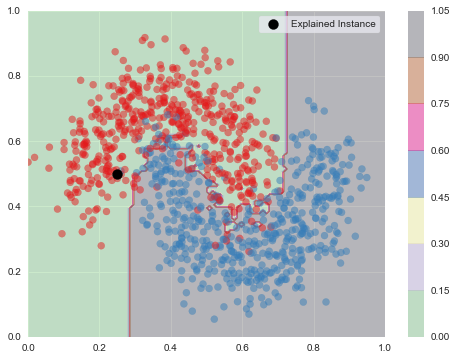

In [60]:
# plot global, local with ridge, local with decision tree
Z = global_model.predict(np.c_[xx.ravel(), yy.ravel()])   
Z = Z.reshape(xx.shape)
plt.figure(figsize=(8, 6))
# plt.title('Global Model')
cs = plt.contourf(xx, yy, Z,
                  cmap=plt.cm.Accent, alpha=.4, vmax=1.0, vmin=0.0)
cbar = plt.colorbar(cs)
plt.scatter(test[:, 0], test[:, 1],
            c=labels_test, cmap=cmap_red_blue, alpha=.5)  # , label='Sampled Data'
plt.scatter(point[0], point[1],
            c='k', s=100, label='Explained Instance')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.legend(frameon=True, framealpha=.75)

plt.savefig(
    f'surrogate_global_model.pdf',
    dpi=300,
    bbox_inches='tight',
    pad_inches=0)

#### Local model -- linear surrogate ####

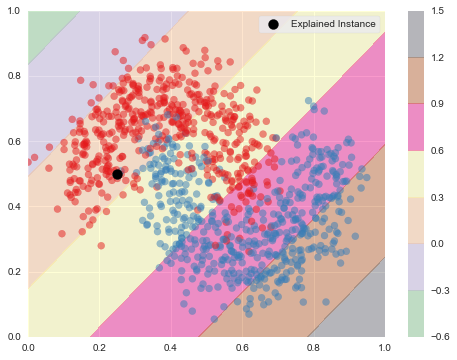

In [61]:
Z = ridge.predict(np.c_[xx.ravel(), yy.ravel()])   
Z = Z.reshape(xx.shape)
plt.figure(figsize=(8, 6))
# plt.title('Local Ridge Model')
cs = plt.contourf(xx, yy, Z,
                  cmap=plt.cm.Accent, alpha=.4, levels=np.arange(-.6, 1.6, .3))
cbar = plt.colorbar(cs)
plt.scatter(test[:, 0], test[:, 1],
            c=labels_test, cmap=cmap_red_blue, alpha=.5)  # , label='Sampled Data'
plt.scatter(point[0], point[1],
            c='k', s=100, label='Explained Instance')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.legend(frameon=True, framealpha=.75)

plt.savefig(
    f'surrogate_local_ridge.pdf',
    dpi=300,
    bbox_inches='tight',
    pad_inches=0)

#### Local model -- tree surrogate ####

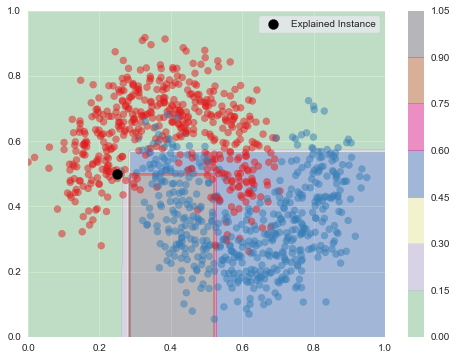

In [62]:
Z = tree.predict(np.c_[xx.ravel(), yy.ravel()])   
Z = Z.reshape(xx.shape)
plt.figure(figsize=(8, 6))
# plt.title('Local Tree')
cs = plt.contourf(xx, yy, Z,
                  cmap=plt.cm.Accent, alpha=.4, vmax=1.0, vmin=0.0)
cbar = plt.colorbar(cs)
plt.scatter(
    test[:, 0], test[:, 1],
    c=labels_test, cmap=cmap_red_blue, alpha=.5)  # , label='Sampled Data'
plt.scatter(point[0], point[1],
            c='k', s=100, label='Explained Instance')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.legend(frameon=True, framealpha=.75)

plt.savefig(
    f'surrogate_local_tree.pdf',
    dpi=300,
    bbox_inches='tight',
    pad_inches=0)